<a href="https://colab.research.google.com/github/fabrizi0rigodanz0/Bitcoin_Transactions_Analysis/blob/main/notebook/Bitcoin_Transactions_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analyzing Bitcoin Transactions with Pandas and Spark

In [4]:
import sys
import os

IN_COLAB = 'google.colab' in sys.modules
WITH_SPARK = IN_COLAB

## Install software

This cell installs the software needed to run the project.

In [5]:
if( WITH_SPARK):
    !apt-get install openjdk-17-jdk-headless
    !apt-get wget
    !pip install pyspark==3.5.0
    !wget https://repos.spark-packages.org/graphframes/graphframes/0.8.3-spark3.5-s_2.13/graphframes-0.8.3-spark3.5-s_2.13.jar
    os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars graphframes-0.8.3-spark3.5-s_2.13.jar pyspark-shell'
    os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

!pip install gdown
!mkdir checkpoint



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  openjdk-17-jre-headless
Suggested packages:
  openjdk-17-demo openjdk-17-source libnss-mdns fonts-dejavu-extra fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-17-jdk-headless openjdk-17-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 45 not upgraded.
Need to get 119 MB of archives.
After this operation, 271 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jre-headless amd64 17.0.10+7-1~22.04.1 [48.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jdk-headless amd64 17.0.10+7-1~22.04.1 [71.1 MB]
Fetched 119 MB in 1s (81.8 MB/s)
Selecting previously unselected package openjdk-17-jre-headless:amd64.
(Reading database ... 1

## Setup

The following cell will import the used packages.

In [6]:
from zipfile import ZipFile
import time
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns

In [7]:
if( WITH_SPARK):
    import pyspark
    import pyspark.pandas as ps
    from pyspark.sql import SparkSession
    from pyspark.sql.types import *
    from pyspark.sql.functions import *
    from pyspark.ml.linalg import Vectors
    from pyspark.ml.clustering import KMeans
    from pyspark.ml.evaluation import *
    from pyspark.ml.feature import *

## Dataset

In this project, you will be asked to perform analysis of [Bitcoin](https://en.wikipedia.org/wiki/Bitcoin) transactions, a cryptocurrency where transactions are stored in blocks of a blockchain - for the purpose of this project, a blockchain can be seen as a list of blocks, and each block has a list of transactions.

The provided data files include a list of transactions performed in Bitcoin. The list of transactions is continuous and ordered in time, being a subset of all transactions performed in Bitcoin. A transaction transfers currency from one or more source addresses to one or more destination addresses.

The datasets are a transformation form the data provided at [https://www.kaggle.com/shiheyingzhe/datasets](https://www.kaggle.com/shiheyingzhe/datasets).




The data sets are available in the following link: [https://drive.google.com/drive/folders/1WSJTm5nfy64uOc648TJ-SI1CHj5MbiH_?usp=sharing](https://drive.google.com/drive/folders/1WSJTm5nfy64uOc648TJ-SI1CHj5MbiH_?usp=sharing). For running locally download the smallest file and at least another one and store it in directory data. For running in Google Colab, you should access the link and Add Shortcut to your Drive.

In [15]:
from google.colab import drive
drive.mount('/content/drive')

# If you added the shortcut to your drive, the file should appear in this directory
# If not, you need to explore from directory /content/drive
!ls /content/drive/MyDrive/sbe2324ada

Mounted at /content/drive
0-68732.csv.gz	      260001-270000.csv.gz  320001-329999.csv.gz  360001-364000.csv.gz
190001-209999.csv.gz  270001-280000.csv.gz  330000-337000.csv.gz  364001-367000.csv.gz
210000-224000.csv.gz  280001-290000.csv.gz  337001-343000.csv.gz  367001-369999.csv.gz
224001-234000.csv.gz  290001-300000.csv.gz  343001-349000.csv.gz  btc_price.csv
234001-247000.csv.gz  300001-310000.csv.gz  349001-354000.csv.gz  labels
247001-260000.csv.gz  310001-320000.csv.gz  354001-360000.csv.gz


In [16]:
DATASET_DIR = "bitcoin/archive1"
# FOR running in Colab
DATASET_DIR = "/content/drive/MyDrive/sbe2324ada"

# Small dataset
TXDATA_FILE = "0-68732.csv.gz"

# Larger dataset
TXDATA_FILE2 = "224001-234000.csv.gz"

# Bitcoin price
BTCPRICE_FILE = "btc_price.csv"

### Bitcoin transactions

Each transactions CSV file has five columns, with the following contents:

* **TxId**: a string of format "block:counter" - this can be used to identify univocally a transaction.
* **Height**: the block in which the transaction is recorded.
* **Input**: list of source addresses.
* **Output**: list of destination addresses; when the list included multiple values, it includes the value transferred for each account. The following example represented two destination addresses, the first receiving *0.01* and the second *49.99*:  
```[['1Fmjwt8172FZT5XdKnzTUcEEzc1T2MCg2a', '0.01'], ['1AbHNFdKJeVL8FRZyRZoiTzG9VCmzLrtvm', '49.99']]```
* **Sum**: a list with a single element that is the sum of the value transferred.
* **Time**: the time of the transaction.


The following cells print basic infomation about the transaction files stored in the directory. The first uses Pandas, while the next two use Pandas interface for Spark.

In [ ]:
# Dumps basic infomation using Spark Pandas API
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

# Dumps basic infomation using native Pandas
print( "DUMP BASIC INFO FOR EACH FILE")
for filename in os.listdir(DATASET_DIR) :
    if( not filename.endswith(".csv.gz")):
        continue;
    print( "FILENAME : " + filename )
    path = os.path.join(DATASET_DIR, filename)
    df = ps.read_csv( path,compression="gzip")
    print( "Number of transactions : " + str(df.shape[0]))
    print( "First block : " + str(df["Height"].min()))
    print( "Last block : " + str(df["Height"].max()))
    print( "First date : " + str(df["Time"].min()))
    print( "Last date : " + str(df["Time"].max()))
    del df


DUMP BASIC INFO FOR EACH FILE
FILENAME : 0-68732.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 14832
First block : 546
Last block : 68732
First date : 2009-01-15 06:08:20
Last date : 2010-07-17 16:54:44
FILENAME : 190001-209999.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 4183123
First block : 190001
Last block : 209999
First date : 2012-07-19 09:43:01
Last date : 2014-03-12 22:49:29
FILENAME : 210000-224000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 4372368
First block : 210000
Last block : 224000
First date : 2012-09-06 14:25:44
Last date : 2014-03-13 09:37:24
FILENAME : 224001-234000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3268711
First block : 224001
Last block : 234000
First date : 2012-08-24 18:14:12
Last date : 2013-05-01 03:47:20
FILENAME : 234001-247000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3755673
First block : 234001
Last block : 247000
First date : 1972-09-04 19:15:29
Last date : 2083-06-22 23:32:50
FILENAME : 247001-260000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3605859
First block : 247001
Last block : 260000
First date : 2013-07-15 11:31:03
Last date : 2014-03-16 01:06:12
FILENAME : 260001-270000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 2769663
First block : 260001
Last block : 270000
First date : 2013-09-23 08:31:57
Last date : 2070-04-24 08:28:17
FILENAME : 270001-280000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3661019
First block : 270001
Last block : 280000
First date : 2013-11-14 13:02:11
Last date : 2014-03-16 13:29:27
FILENAME : 280001-290000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 2445208
First block : 283895
Last block : 290000
First date : 2014-02-03 04:53:17
Last date : 2014-03-16 13:45:30
FILENAME : 290001-300000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3848932
First block : 290001
Last block : 300000
First date : 2013-03-18 16:57:27
Last date : 2014-05-10 06:32:34
FILENAME : 300001-310000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3771780
First block : 300001


In [ ]:
# Dumps basic infomation using native Pandas
print( "DUMP BASIC INFO FOR EACH FILE")
for filename in os.listdir(DATASET_DIR) :
    if( not filename.endswith(".csv.gz")):
        continue;
    print( "FILENAME : " + filename )
    date_cols = ["Time"]
    path = os.path.join(DATASET_DIR, filename)
    df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)
    print( "Number of transactions : " + str(df.shape[0]))
    print( "First block : " + str(df["Height"].min()))
    print( "Last block : " + str(df["Height"].max()))
    print( "First date : " + str(df["Time"].min()))
    print( "Last date : " + str(df["Time"].max()))
    del df


DUMP BASIC INFO FOR EACH FILE
FILENAME : 0-68732.csv.gz
Number of transactions : 14832
First block : 546
Last block : 68732
First date : 2009-01-15 06:08:20
Last date : 2010-07-17 16:54:44
FILENAME : 190001-209999.csv.gz
Number of transactions : 4183123
First block : 190001
Last block : 209999
First date : 2012-07-19 09:43:01
Last date : 2014-03-12 22:49:29
FILENAME : 210000-224000.csv.gz
Number of transactions : 4372368
First block : 210000
Last block : 224000
First date : 2012-09-06 14:25:44
Last date : 2014-03-13 09:37:24
FILENAME : 224001-234000.csv.gz
Number of transactions : 3268711
First block : 224001
Last block : 234000
First date : 2012-08-24 18:14:12
Last date : 2013-05-01 03:47:20
FILENAME : 234001-247000.csv.gz
Number of transactions : 3755673
First block : 234001
Last block : 247000
First date : 1972-09-04 19:15:29
Last date : 2083-06-22 23:32:50
FILENAME : 247001-260000.csv.gz
Number of transactions : 3605859
First block : 247001
Last block : 260000
First date : 2013-07-

In [ ]:
# Dumps basic infomation using Spark Dataframe load
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

# Dumps basic infomation using native Pandas
print( "DUMP BASIC INFO FOR EACH FILE")
for filename in os.listdir(DATASET_DIR) :
    if( not filename.endswith(".csv.gz")):
        continue;
    print( "FILENAME : " + filename )
    path = os.path.join(DATASET_DIR, filename)
    mySchema = StructType([
        StructField("TxId", StringType()),
        StructField("Height", IntegerType()),
        StructField("Input", StringType()),
        StructField("Output", StringType()),
        StructField("Sum", StringType()),
        StructField("Time", TimestampType()),
    ])

    dataset = spark.read.load(path, format="csv", compression="gzip",
                         sep=",", schema=mySchema, header="true")
    dataset.createOrReplaceTempView("data")

    statistics = spark.sql( """SELECT COUNT( *) AS num_transactions,
                                  MIN( Height) AS first_block,
                                  MAX( Height) AS last_block,
                                  MIN( Time) AS first_time,
                                  MAX( Time) AS last_time
                                  FROM data""")
    statistics.show()


### Prepocessing a dataset file

For simplifying the processing, we will split the transactions dataframe into the following dataframes:

* **inputDF**, includes the index of the transaction, one input address, the sum and the time.
* **outputDF**, includes the index of the transaction, one output address, the output value, the sum and the time.
* **transactionDF**, includes the index of the transaction, the sum and the time.

In [ ]:
date_cols = ["Time"]
path = os.path.join(DATASET_DIR, TXDATA_FILE2)
df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)

df = df.sample(frac=1/10, random_state=42)

df['Input'] = df['Input'].apply(ast.literal_eval)
df['Output'] = df['Output'].apply(ast.literal_eval)

inputDF = df[["TxId","Height","Input","Sum","Time"]].explode("Input")
print(inputDF.dtypes)

outputDF = df[["TxId","Height","Output","Sum","Time"]].explode("Output")
outputDF[["Output","Value"]] = outputDF["Output"].to_list()
print(outputDF.dtypes)

transactionDF = df[["TxId","Height","Sum","Time"]]
print(transactionDF.dtypes)

We repeat the same computation in Spark SQL, creating views with the same names.

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

path = os.path.join(DATASET_DIR, TXDATA_FILE2)
mySchema = StructType([
    StructField("TxId", StringType()),
    StructField("Height", IntegerType()),
    StructField("Input", StringType()),
    StructField("Output", StringType()),
    StructField("Sum", FloatType()),
    StructField("Time", TimestampType()),
])

dataset = spark.read.load(path, format="csv", compression="gzip",
                         sep=",", schema=mySchema, header="true")
dataset = dataset.withColumn("Input",split(regexp_replace("Input","[\[\s\]]",""),"\,"))
dataset = dataset.withColumn("Output",split("Output","\]\, \["))
dataset = dataset.sample(fraction=1/10, seed=42)
dataset.createOrReplaceTempView("data")

inputSDF = spark.sql( """SELECT txid, height, EXPLODE(input) AS input, sum, time
                                  FROM data""")
inputSDF.createOrReplaceTempView("input")
inputSDF.printSchema()


outputSDF = spark.sql( """SELECT txid, height, EXPLODE(output) AS output, sum, time
                                      FROM data""")
outputSDF = outputSDF.withColumn("output",split(regexp_replace("output","[\[\]]",""),"\,"))
outputSDF = outputSDF.withColumn("value",expr("CAST(output[1] AS FLOAT)"))
outputSDF = outputSDF.withColumn("output",expr("output[0]"))
outputSDF.createOrReplaceTempView("output")
outputSDF.printSchema()

transactionSDF = spark.sql( """SELECT txid, height, sum, time
                                  FROM data""")
transactionSDF.createOrReplaceTempView("transaction")
transactionSDF.printSchema()

root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- input: string (nullable = false)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)

root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- output: string (nullable = true)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- value: float (nullable = true)

root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)



### Bitcoin price

This dataset has, for each day, the USD price of one bitcoin. The file is ```btc_price.csv```.


In [ ]:
date_cols = ["Date"]
path = os.path.join(DATASET_DIR, BTCPRICE_FILE)

priceDF = pd.read_csv( path,parse_dates=date_cols)
print(priceDF)
priceDF.dtypes

           Date    Price
0    2009-01-15      0.1
1    2009-01-16      0.1
2    2009-01-17      0.1
3    2009-01-18      0.1
4    2009-01-19      0.1
...         ...      ...
5417 2023-11-15  37874.9
5418 2023-11-16  36161.2
5419 2023-11-17  36595.4
5420 2023-11-18  36568.6
5421 2023-11-19  36792.1

[5422 rows x 2 columns]


Date     datetime64[ns]
Price           float64
dtype: object

### Bitcoin tags

This dataset includes a set of files with different types of addresses.
Currently there are several files for different types of entities.

A new dataset file, easier to process, will be made available soon in the same directory.


## Part 0

This example computes, for each address, the number of transactions in which the address has been involved.

We have the code using Spark and Pandas, printing the time for doing the computation.
**Draw some conclusions** by comparing the time for performing the computation using Spark and Pandas, and also when using the different datasets - **Make sure you run each cell more than once and write down the last value**.

### Pandas code

In [ ]:
start_time = time.time()

date_cols = ["Time"]
path = os.path.join(DATASET_DIR, TXDATA_FILE2)
df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)

df['Input'] = df['Input'].apply(ast.literal_eval)
df['Output'] = df['Output'].apply(ast.literal_eval)

inputDF = df[["TxId","Height","Input","Sum","Time"]].explode("Input")

outputDF = df[["TxId","Height","Output","Sum","Time"]].explode("Output")
#outputDF[["Output","Value"]] = outputDF["Output"].to_list()
outputDF = outputDF.dropna(subset=['Output'])  # Remove NaNs if any
outputDF['Output'], outputDF['Value'] = zip(*outputDF['Output'].apply(lambda x: x if len(x) == 2 else (None, None)))

addr_in = inputDF[['Input','TxId']].groupby('Input').count().rename(columns={'TxId':"cnt_in"})
addr_out = outputDF[['Output','TxId']].groupby('Output').count().rename(columns={'TxId':"cnt_out"})
addr=addr_in.join(addr_out,how="outer").fillna(0)
addr["cnt"] = addr["cnt_in"] + addr["cnt_out"]
print(addr.nlargest(10,"cnt"))


end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


                                     cnt_in   cnt_out       cnt
1dice8EMZmqKvrGE4Qc9bUFf9PX3xaYDp  156000.0  154285.0  310285.0
1dice97ECuByXAvqXpaYzSaQuPVvrtmz6  145342.0  145236.0  290578.0
1dice9wcMu5hLF4g81u8nioL5mmSHTApw   89521.0   89427.0  178948.0
1dice7fUkz5h4z2wPc1wLMPWgB5mDwKDx   69890.0   69741.0  139631.0
1dice7W2AicHosf5EL3GFDUVga7TgtPFn   63969.0   63892.0  127861.0
1VayNert3x1KzbpzMGt2qdqrAThiRovi8   52129.0   52297.0  104426.0
1diceDCd27Cc22HV3qPNZKwGnZ8QwhLTc   50376.0   50032.0  100408.0
1dice1e6pdhLzzWQq7yMidf6j8eAg7pkY   44032.0   44241.0   88273.0
1dice6YgEVBf88erBFra9BHf6ZMoyvG88   39163.0   39059.0   78222.0
1dice7EYzJag7SxkdKXLr8Jn14WUb3Cf1   37015.0   36795.0   73810.0
Runtime = 235.94536519050598


### Results (Pandas)

The time to process the small dataset was : **0.8033947944641113** seconds.

The time to process the large dataset was : **235.94536519050598** seconds.

### Spark SQL code

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

start_time = time.time()

path = os.path.join(DATASET_DIR, TXDATA_FILE2)
mySchema = StructType([
    StructField("TxId", StringType()),
    StructField("Height", IntegerType()),
    StructField("Input", StringType()),
    StructField("Output", StringType()),
    StructField("Sum", FloatType()),
    StructField("Time", TimestampType()),
])

dataset = spark.read.load(path, format="csv", compression="gzip",
                         sep=",", schema=mySchema, header="true")
dataset = dataset.withColumn("Input",split(regexp_replace("Input","[\[\s\]]",""),"\,"))
dataset = dataset.withColumn("Output",split("Output","\]\, \["))
dataset.createOrReplaceTempView("data")

inputSDF = spark.sql( """SELECT txid, height, EXPLODE(input) AS input, sum, time
                                  FROM data""")
inputSDF.createOrReplaceTempView("input")

outputSDF = spark.sql( """SELECT txid, height, EXPLODE(output) AS output, sum, time
                                      FROM data""")
outputSDF = outputSDF.withColumn("output",split(regexp_replace("output","[\[\]]",""),"\,"))
outputSDF = outputSDF.withColumn("value",expr("CAST(output[1] AS FLOAT)"))
outputSDF = outputSDF.withColumn("output",expr("output[0]"))
outputSDF.createOrReplaceTempView("output")

spark.sql( """SELECT i.addr, cnt_in + cnt_out AS cnt, cnt_in, cnt_out FROM (
              (SELECT input AS addr, COUNT(*) AS cnt_in FROM input GROUP BY input) i FULL OUTER JOIN
              (SELECT output AS addr, COUNT(*) AS cnt_out FROM output GROUP BY output) o ON i.addr = o.addr)
                ORDER BY cnt DESC
                LIMIT 10""").show(truncate=False)
end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


+-----------------------------------+------+------+-------+
|addr                               |cnt   |cnt_in|cnt_out|
+-----------------------------------+------+------+-------+
|'1dice8EMZmqKvrGE4Qc9bUFf9PX3xaYDp'|310285|156000|154285 |
|'1dice97ECuByXAvqXpaYzSaQuPVvrtmz6'|290578|145342|145236 |
|'1dice9wcMu5hLF4g81u8nioL5mmSHTApw'|178948|89521 |89427  |
|'1dice7fUkz5h4z2wPc1wLMPWgB5mDwKDx'|139631|69890 |69741  |
|'1dice7W2AicHosf5EL3GFDUVga7TgtPFn'|127861|63969 |63892  |
|'1VayNert3x1KzbpzMGt2qdqrAThiRovi8'|104426|52129 |52297  |
|'1diceDCd27Cc22HV3qPNZKwGnZ8QwhLTc'|100408|50376 |50032  |
|'1dice1e6pdhLzzWQq7yMidf6j8eAg7pkY'|88273 |44032 |44241  |
|'1dice6YgEVBf88erBFra9BHf6ZMoyvG88'|78222 |39163 |39059  |
|'1dice7EYzJag7SxkdKXLr8Jn14WUb3Cf1'|73810 |37015 |36795  |
+-----------------------------------+------+------+-------+

Runtime = 109.76431059837341


### Results (Spark)

The time to process the small dataset was : **1.6324033737182617** seconds.

The time to process the large dataset was : **109.18929481506348** seconds.



### Discussion:

PySpark is ideal for large databases due to its distributed computing and in-memory processing, enabling fast, parallel processing of big data across multiple machines. This is the reason why it is much faster than pandas in doing calculations on the larger dataset.
However the parallel processing metod utilized is not efficient when dealing with small dataset as transferring data from a machine to another is an expensive task in terms of time.
For this reason Pandas is better for smaller datasets. It operates efficiently on a single machine with an in-memory data structure, offering fast data manipulation with a simple syntax.



## Part 1

This first group consists in computing some statistics on the infomration available in the dataset.

The smallest dataset might lead to strange results for some statistics. Use it while you are developing you project, but if you run into strange results, just use a larger one.




### Top-10 largest transactions

Display the top 10 largest transactions in terms of bitcoin currency.

In [ ]:
transactionSDF.createOrReplaceTempView("transactions")
top10 = spark.sql("""
    SELECT *
    FROM transactions
    ORDER BY Sum DESC
    LIMIT 10
""")
top10.show()


+---------+------+---------+-------------------+
|     txid|height|      sum|               time|
+---------+------+---------+-------------------+
|230689:12|230689|21434.684|2013-04-10 19:22:31|
| 224249:1|224249|21266.498|2013-03-04 16:43:10|
| 233977:0|233977|15116.423|2013-05-01 00:25:58|
| 231692:0|231692|  14999.0|2013-04-16 20:12:45|
| 233065:0|233065|14995.875|2013-04-25 12:12:28|
| 225171:0|225171|13854.495|2013-03-10 10:58:55|
|231521:39|231521|12653.816|2013-04-15 20:24:44|
| 226024:0|226024|11459.878|2013-03-15 16:39:43|
| 231849:0|231849|  11102.9|2013-04-17 18:13:53|
| 231889:6|231889|10838.701|2013-04-18 00:07:35|
+---------+------+---------+-------------------+



### Top-10 largest transactions (in USD)

Display the top 10 largest transactions in terms of bitcoin currency.

In [ ]:
from pyspark.sql.types import DateType

priceSchema = StructType([
    StructField("Date", DateType()),
    StructField("Price", FloatType()),
])

# Load the CSV file into a Spark DataFrame
path = os.path.join(DATASET_DIR, BTCPRICE_FILE)
priceDF = spark.read.csv(path, schema=priceSchema, header=True)

priceDF.createOrReplaceTempView("price_data")

resultDF = spark.sql("SELECT * FROM price_data")


In [ ]:
from pyspark.sql.functions import to_date, to_timestamp, col

# Convert 'Time' to datetime format and create a 'Date' column in transactionSDF
transactionSDF = transactionSDF.withColumn("Time", to_timestamp("Time"))
transactionSDF = transactionSDF.withColumn("Date", to_date("Time"))

# Convert 'Date' to date format in priceDF
priceDF = priceDF.withColumn("Date", to_date("Date"))

transactionSDF.createOrReplaceTempView("transaction_data")
priceDF.createOrReplaceTempView("price_data")

# Joining the two datasets on 'Date'
df_joined = spark.sql("""
    SELECT t.*, p.Price, t.Sum * p.Price as USD_Value
    FROM transaction_data t
    JOIN price_data p ON t.Date = p.Date
""")

# Registering the joined DataFrame as a temporary view
df_joined.createOrReplaceTempView("joined_data")

# Calculating the 10 largest transactions in USD and displaying them
top_10 = spark.sql("""
    SELECT *
    FROM joined_data
    ORDER BY USD_Value DESC
    LIMIT 10
""")
top_10.show()

+----------+------+---------+-------------------+----------+-----+---------+
|      txid|height|      sum|               Time|      Date|Price|USD_Value|
+----------+------+---------+-------------------+----------+-----+---------+
| 230689:12|230689|21434.684|2013-04-10 19:22:31|2013-04-10|165.0|3536722.8|
|  233065:0|233065|14995.875|2013-04-25 12:12:28|2013-04-25|141.7|2124915.5|
|  233977:0|233977|15116.423|2013-05-01 00:25:58|2013-05-01|116.4|1759551.6|
| 230691:53|230691|  9434.66|2013-04-10 19:34:39|2013-04-10|165.0|1556718.9|
|232937:291|232937| 9976.466|2013-04-24 16:15:09|2013-04-24|154.2|1538371.0|
|  230684:0|230684|   9000.0|2013-04-10 18:52:41|2013-04-10|165.0|1485000.0|
|  233013:0|233013|  9999.99|2013-04-25 04:28:00|2013-04-25|141.7|1416998.6|
| 230707:15|230707|   7723.0|2013-04-10 21:45:59|2013-04-10|165.0|1274295.0|
|  231889:6|231889|10838.701|2013-04-18 00:07:35|2013-04-18|109.0|1181418.4|
| 231891:24|231891|10819.958|2013-04-18 00:07:47|2013-04-18|109.0|1179375.4|

### Evolution of the number of transactions over time

Display a graph that shows the evolution of the number of transactions over time.


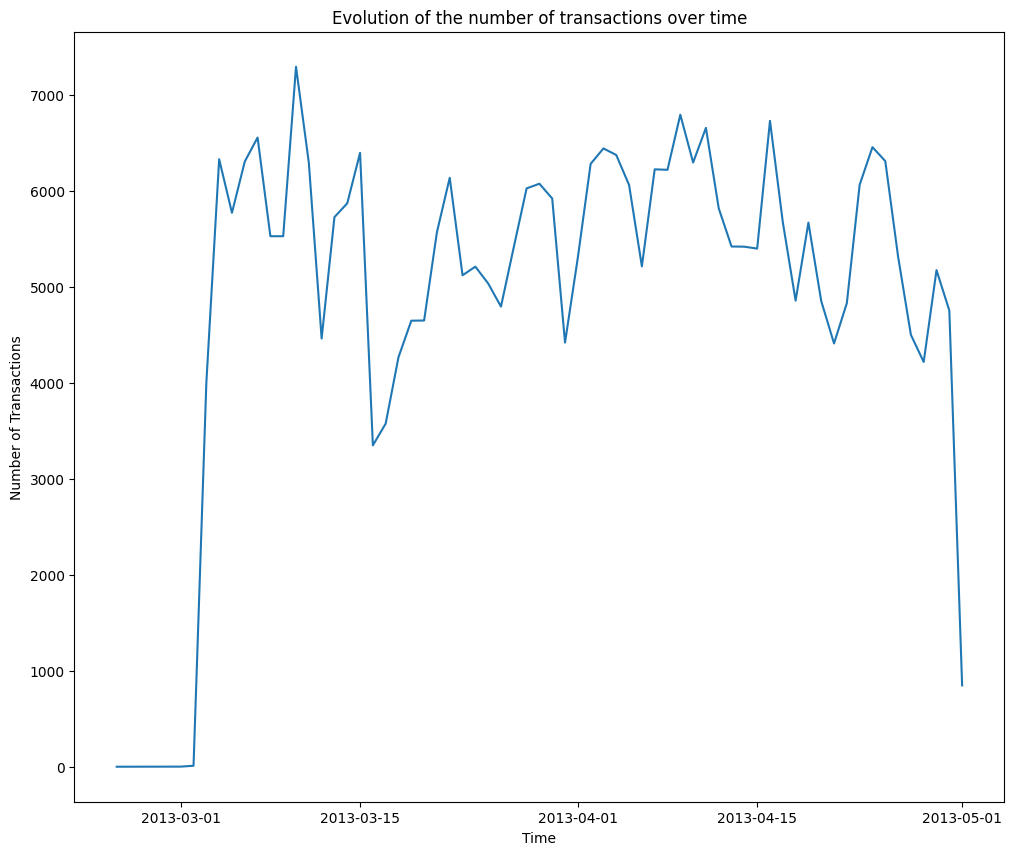

In [ ]:
from pyspark.sql.functions import to_date

# Convert 'Time' to date format
transactionSDF = transactionSDF.withColumn("Time", to_date("Time"))

transactionSDF.createOrReplaceTempView("transaction_data")

transactionDF3 = spark.sql("""
    SELECT Time, COUNT(*) as cnt
    FROM transaction_data
    GROUP BY Time
    ORDER BY Time
""")

import matplotlib.pyplot as plt

# Collect the data for plotting
plot_data = transactionDF3.collect()

# Extracting Time and cnt for plotting
times = [row['Time'] for row in plot_data]
counts = [row['cnt'] for row in plot_data]

# Plotting using Matplotlib
plt.figure(figsize=(12, 10))
plt.plot(times, counts)
plt.xlabel('Time')
plt.ylabel('Number of Transactions')
plt.title('Evolution of the number of transactions over time')
plt.show()

### Evolution of currency transferred over time

Display a graph that shows the evolution of the amount of currency transferred (in BTC and USD) over time.


In [ ]:
from pyspark.sql.functions import to_date, col

# Convert 'Date' to date format and sort priceDF
priceDF = priceDF.withColumn("Date", to_date("Date"))
priceDF = priceDF.orderBy("Date")

# Register priceDF as a temporary view
priceDF.createOrReplaceTempView("price_data")

# Group by 'Time' and sum the 'Sum' column in transactionSDF
transactionSDF.createOrReplaceTempView("transaction_data")
transactionDF4 = spark.sql("""
    SELECT Time, SUM(Sum) as Sum
    FROM transaction_data
    GROUP BY Time
""")

# Register the resulting DataFrame as a temporary view
transactionDF4.createOrReplaceTempView("grouped_transaction_data")

# Join the DataFrames
mergedDF = spark.sql("""
    SELECT t.Time, t.Sum, p.Price, (t.Sum * p.Price) as USD
    FROM grouped_transaction_data t
    INNER JOIN price_data p ON t.Time = p.Date
""")

# Rename 'Sum' to 'BTC'
mergedDF = mergedDF.withColumnRenamed("Sum", "BTC")

# Register the joined DataFrame as a temporary view
mergedDF.createOrReplaceTempView("merged_data")

# Order by 'Time'
mergedDF = spark.sql("""
    SELECT Time, BTC, USD
    FROM merged_data
    ORDER BY Time
""")


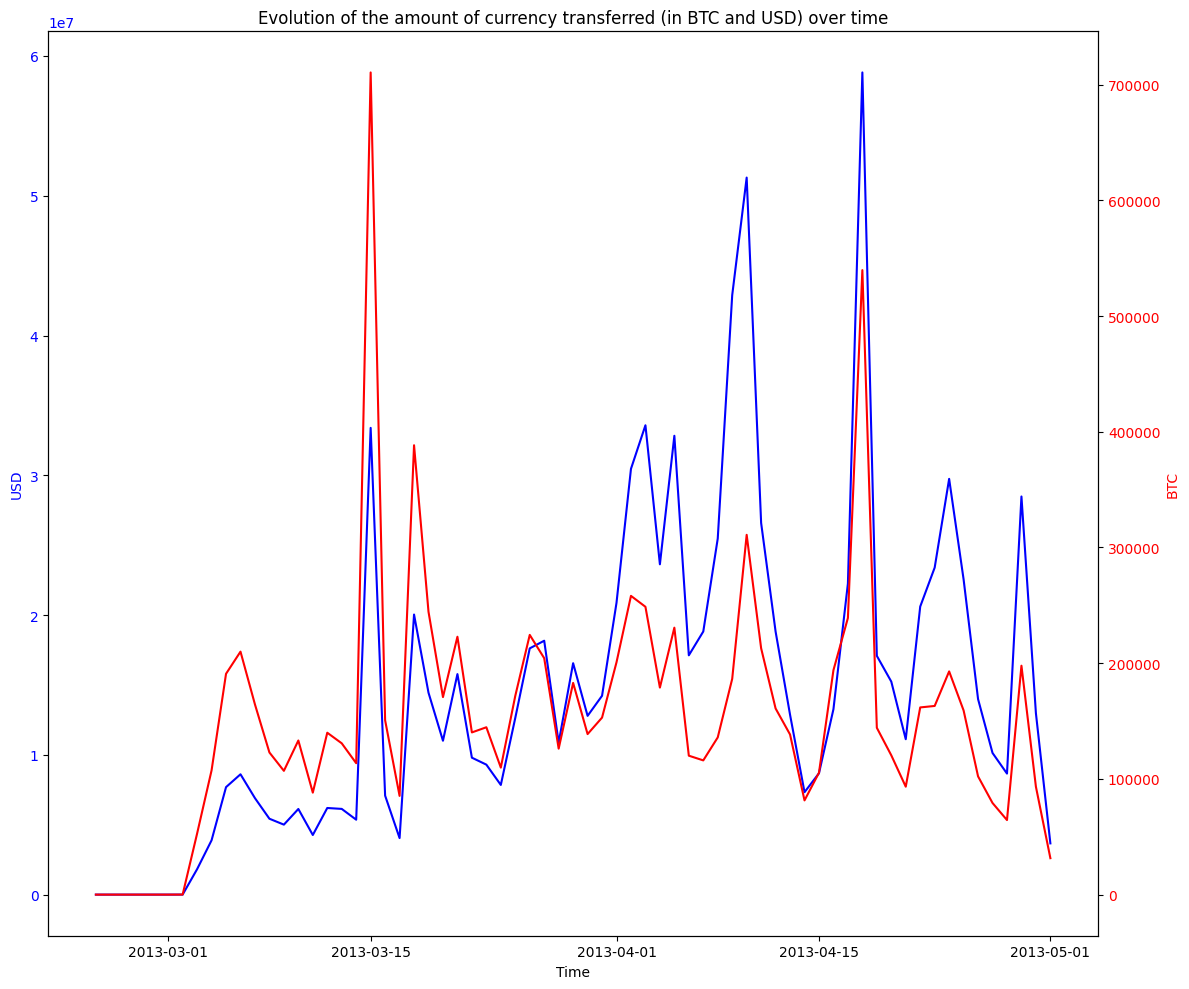

In [ ]:
import matplotlib.pyplot as plt

# Collect the data for plotting
plot_data = mergedDF.collect()

# Extract 'Time', 'BTC', and 'USD' for plotting
times = [row['Time'] for row in plot_data]
usd_values = [row['USD'] for row in plot_data]
btc_values = [row['BTC'] for row in plot_data]

# Creating the plot
fig, ax1 = plt.subplots(figsize=(12, 10))

# Plot the 'USD' data
ax1.plot(times, usd_values, label='USD', color='b')
ax1.set_xlabel('Time')
ax1.set_ylabel('USD', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary y-axis for 'BTC'
ax2 = ax1.twinx()
ax2.plot(times, btc_values, label='BTC', color='r')
ax2.set_ylabel('BTC', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Evolution of the amount of currency transferred (in BTC and USD) over time')
fig.tight_layout()  # Adjust the layout
plt.show()

## Part 2

Assume you want to create a web site with infomration about bitcoin. In this website, a user could go and get some statistics for any Bitcoin address. You can select the statistics you want to maintain - you should maintain at least three statistics - suggestions: address account balance (mandatory); top-3 commercial partners; average transaction value.

To support this web site, it would be necessary to build one or more indices that would be used to answer the query of the user. In this context a index is a table that maps an address to a value of the statistics being computed.

Write the code to build these indices - for each index, print 5 lines.

**NOTE:** use the data from a single dataset file (even knowing that the value of the account balance would need to include processing all transactions).


In [ ]:
df_joined = inputDF.join(outputDF.set_index('TxId'), on= 'TxId', how= 'outer', rsuffix='_output')
df_joined.drop(['Sum_output', 'Time_output'], axis= 1, inplace= True)


In [ ]:
# Group by 'Input' in input_df and sum the 'Sum' column
input_sums = inputDF.groupby('Input')['Sum'].sum()

# Group by 'Output' in output_df and sum the 'Value' column
output_sums = outputDF.groupby('Output')['Value'].sum()

# Combine the two series into a single dataframe, with input sums being subtracted and output sums added
balance_df = pd.DataFrame({'Balance': output_sums}).join(pd.DataFrame({'Balance': -input_sums}), how='outer', lsuffix='_out', rsuffix='_in')

# Fill NaN values with 0 and sum the balances
balance_df['Balance'] = balance_df.fillna(0)['Balance_out'] + balance_df.fillna(0)['Balance_in']

# Sort the dataframe by balance in descending order
balance_df = balance_df.sort_values(by='Balance', ascending=False)

In [ ]:
#IMPORTANT!! Restart the kernel without PySpark before running this
# Let's start by calculating some statistics, we'll start by calculating the age of each address:

# Convert the 'Time' column to datetime if not already done
inputDF['Time'] = pd.to_datetime(inputDF['Time'])
outputDF['Time'] = pd.to_datetime(outputDF['Time'])

# Calculate the earliest and latest times using pandas methods
earliest_time = min(inputDF['Time'].min(), outputDF['Time'].min())
latest_time = max(inputDF['Time'].max(), outputDF['Time'].max())
total_period = (latest_time - earliest_time).days

# Calculating the age of each address in days
first_input_time = inputDF.groupby('Input')['Time'].min()
first_output_time = outputDF.groupby('Output')['Time'].min()

# Combining the first transaction times
first_transaction_time = pd.concat([first_input_time, first_output_time], axis=1)
first_transaction_time['First_Time'] = first_transaction_time.min(axis=1)

# Calculating the age of each address
address_age = (latest_time - first_transaction_time['First_Time']).dt.days

# The 'address_age' series now contains the age of each address in days
address_age_df = address_age.reset_index()
address_age_df.columns = ['Address', 'address_age']
#address_age_df.head()

In [ ]:
# Calculate total transaction values for each address in the input and output dataframes
input_total_values = inputDF.groupby('Input')['Sum'].sum()
output_total_values = outputDF.groupby('Output')['Value'].sum()

# Calculate transaction counts for each address in the input and output dataframes
input_transaction_counts = inputDF.groupby('Input').size()
output_transaction_counts = outputDF.groupby('Output').size()

# Combine total values and counts for each address
total_values = input_total_values.add(output_total_values, fill_value=0)
transaction_counts = input_transaction_counts.add(output_transaction_counts, fill_value=0)

# Calculate the average transaction value for each address
average_transaction_values = total_values / transaction_counts

# Sort the series by average transaction value in descending order
average_transaction_values_sorted = average_transaction_values.sort_values(ascending=False)

average_transaction_values_sorted.head(10) # Display the top 10 addresses by average transaction value

# Convert the series to a DataFrame and reset the index
average_transaction_values_df = average_transaction_values_sorted.reset_index()
average_transaction_values_df.columns = ['Address', 'Average_Transaction_Value']


average_transaction_values_df['Average_Transaction_Value_Per_Day']= average_transaction_values_df['Average_Transaction_Value']/ total_period
average_transaction_values_df['Average_Transaction_Value_Per_Week']= average_transaction_values_df['Average_Transaction_Value']/ (total_period/7)
average_transaction_values_df['Average_Transaction_Value_Per_Month']= average_transaction_values_df['Average_Transaction_Value']/ (total_period/30)
average_transaction_values_df['Average_Transaction_Value_Per_Quarter']= average_transaction_values_df['Average_Transaction_Value']/ (total_period/91)

#average_transaction_values_df.head()

In [ ]:
# Number of times that the address appears in the Input
N_of_input = inputDF.groupby('Input').size().astype(float)
N_of_input = N_of_input.reset_index()
N_of_input.columns = ['Address', 'N_of_Inputs']

#display(N_of_input.head())

# Number of times that the address appears in the Output
N_of_output = outputDF.groupby('Output').size()
N_of_output = N_of_output.reset_index()
N_of_output.columns = ['Address', 'N_of_Output']

#display(N_of_output.head())

# Merging the two datasets
input_output_df = N_of_input.merge(N_of_output, on='Address', how='left').fillna(0)
#display(input_output_df.head())

In [ ]:
# Extracting the 'Input' and 'Output' columns
input_addresses = inputDF['Input']
output_addresses = outputDF['Output']

# Concatenating and dropping duplicates to get unique addresses
unique_addresses = pd.concat([input_addresses, output_addresses]).drop_duplicates().reset_index(drop=True)

# Creating a new dataframe with these unique addresses
websiteDF = pd.DataFrame(unique_addresses, columns=['Address'])

websiteDF = websiteDF.merge(address_age_df, on='Address', how='left')

# Display the first few rows of the new dataframe
websiteDF = websiteDF.merge(balance_df, left_on='Address', right_index=True, how='left')

# Display the first few rows of the final merged dataframe
websiteDF = websiteDF.merge(input_output_df, on='Address', how='left').fillna(0)

# Merge the average transaction values DataFrame with the address_df DataFrame
websiteDF = websiteDF.merge(average_transaction_values_df, on='Address', how='left')

websiteDF

,Address,address_age,Balance_out,Balance_in,Balance,N_of_Inputs,N_of_Output,Average_Transaction_Value,Average_Transaction_Value_Per_Day,Average_Transaction_Value_Per_Week,Average_Transaction_Value_Per_Month,Average_Transaction_Value_Per_Quarter
0,1dice97ECuByXAvqXpaYzSaQuPVvrtmz6,62,5454.509437,-25515.019600,-20060.510164,14504.0,14324.0,1.074286,0.017327,0.12129,0.519816,1.576775
1,1HcdBWHCEkMf6WgTnjAse6Q5LWtNu5tAqW,32,0.000000,-1.732852,-1.732852,1.0,0.0,1.732852,0.027949,0.195645,0.838477,2.543379
2,1DASNHJLuqkwezyNLStC85s5d92FuutqiJ,17,0.014466,-0.012288,0.002178,1.0,1.0,0.013377,0.000216,0.00151,0.006473,0.019634
3,1EkUCz9okAjBofU7HEGXkNo61cCJTsqLPA,17,0.000000,-0.012288,-0.012288,1.0,0.0,0.012288,0.000198,0.001387,0.005946,0.018036
4,1C6K5PJUU8oe9GxVPDbRH1cs6FDbHMQNHs,23,0.000000,-23.322033,-23.322033,1.0,0.0,23.322033,0.376162,2.633133,11.284855,34.230726
...,...,...,...,...,...,...,...,...,...,...,...,...
619443,13FoML1UvV2YEjZud4Js4Jq1stLrSos8ie,10,0.120231,0.000000,0.120231,0.0,0.0,0.120231,0.001939,0.013574,0.058176,0.176468
619444,19udyqxHeoNRiHA6RF3zeCgw1qbn4xQorD,45,17.388604,0.000000,17.388604,0.0,0.0,17.388604,0.280461,1.963229,8.413841,25.521983
619445,1NGistC71QWeWE7Lp78pc91iyFxKqx1EWX,45,5.400000,0.000000,5.400000,0.0,0.0,5.4,0.087097,0.609677,2.612903,7.925806
619446,12RZy8rfyWY8GZX2uCMuadxYguvALQAPBa,32,40.377926,0.000000,40.377926,0.0,0.0,40.377926,0.651257,4.558798,19.537706,59.264376


#### Discussion

**1) Balance**

The code calculates the net balance for each address in a cryptocurrency transaction dataset by:

1. Summing the transaction amounts for each address in the 'Input' column of inputDF, which likely represents the total sent by each address.
2. Summing the transaction values for each address in the 'Output' column of outputDF, likely representing the total received.
3. Combining these sums into a single DataFrame, subtracting the inputs from the outputs to get a net balance for each address.
4. Filling any missing values with zero, since an outer join ensures all addresses are included, even if they don't appear in both DataFrames.
5. Sorting the DataFrame by balance in descending order to identify the addresses with the highest net balance.

**2) Address age**

This code calculates the age of each address in a dataset containing cryptocurrency transactions by:

1. Converting the 'Time' column in both inputDF and outputDF to datetime format.
2. Determining the earliest and latest transaction times across both datasets to establish the total period of the dataset.
3. Grouping transactions by 'Input' and 'Output' addresses to find the earliest transaction time for each address, representing when each address was first used.
4. Combining these times into a single DataFrame and calculating the first transaction time for each address.
5. Computing the age of each address in days by subtracting the first transaction time from the latest transaction time in the dataset.
6. Storing the results in a new DataFrame address_age_df with columns for 'Address' and 'address_age' (the latter representing each address's age in days).



**3) Average transcation values**

This code performs an analysis on cryptocurrency transaction data to determine the average transaction value for each address and then breaks down this average on a per-day, per-week, per-month, and per-quarter basis:

1. It calculates the total transaction value summed over all transactions for each address within the inputDF and outputDF DataFrames.
2. It counts the number of transactions for each address in both DataFrames.
3. These totals and counts are then combined across inputs and outputs, with missing values filled with 0, to ensure that all addresses are accounted for.
4. The average transaction value for each address is computed by dividing the total values by the transaction counts.
5. This average transaction value is sorted in descending order to identify the addresses with the highest average transaction values.
6. The sorted values are displayed for the top 10 addresses.
7. The series is then converted to a DataFrame, and the index is reset to create an 'Address' column.
8. Additional columns are added to the DataFrame to calculate the average transaction value per day, week, month, and quarter based on the total period of the dataset determined earlier.
9. The code to display the top entries of this DataFrame is commented out.

**4) N. of Input/Output**

I calculated the number of times each cryptocurrency address appeared in both the input and output datasets:

1. For the input dataset 'N_of_input', I counted the occurrences of addresses in the 'Input' column, converted the counts to floating-point values, and organized the results into a DataFrame.

2. For the output dataset 'N_of_output', I performed a similar counting process based on the 'Output' column.

3. I merged these two datasets 'input_output_df' by the 'Address' column, filling any missing values with zeros. This merged DataFrame provides the counts of appearances for each address in both input and output data.



## Part 3

Explore the creation of classification models for assigning labels to addresses. Use the labels assigned in the provided dataset for training and testing.

**SUGGESTION:** use statistics associated with each address, including number of transactions, avergae amount of transactions, average number of partners per day (or other time unit), etc.

**NOTE:** building the best classification model is a never ending task, and we do not expect you to build a perfect classifier. What we expect you in this task is that you propose a set of variables and explain the relevance of such variable for helping differentiate between different classes, and that do the step to build and evaluate the classifier.


In [ ]:
# Count the number of transactions for each unique address in both datasets
input_transactions_count = inputDF['Input'].value_counts()
output_transactions_count = outputDF['Output'].value_counts()

# Combine these counts
total_transactions_count = input_transactions_count.add(output_transactions_count, fill_value=0).astype(int)

# Display the first few rows of the combined count
total_transactions_count

#transform total transaction count into a dataframe
total_transactions_count = pd.DataFrame(total_transactions_count)

total_transactions_count = total_transactions_count.reset_index()
total_transactions_count.columns = ['Address', 'total_transactions_count']
total_transactions_count

,Address,total_transactions_count
0,111113SnjKKw5DRXAkMNjVy3h92dcyyhv,3
1,11115sSatmoKpEPvM14YSypWfSzsVef7x,1
2,1111EmUQ4JuLQmz6MbFtr44hY9EDA1u5v,2
3,111213xkVmeHT1v7N7Ff43XmVfLAUq7WEZ,6
4,11146RjYKQbHA39RUXxrQWUb8fzGoHzfU,1
...,...,...
619443,3Qza2TjSp7gTGWLULguXZ65fYzHXqrXrgt,1
619444,3QzbJQpreSTPzVVqpm9FCpHvWJPquep1rA,1
619445,3QzihkgcK52bGhT4pKwim3D1cX3ohWnv7G,1
619446,3QzqXg79Z5THWsi5sk9JnDafSeqybBynUR,1


In [ ]:
#calculate the number of transaction per day, week, month and qarter and normalized

total_transactions_count.reset_index()
total_transactions_count.columns = ['Address', 'Count_transactions']
total_transactions_count['Count_Transactions_Per_Day']= total_transactions_count['Count_transactions']/ total_period
total_transactions_count['Count_Transactions_Per_Week']= total_transactions_count['Count_transactions']/ (total_period/7)
total_transactions_count['Count_Transactions_Per_Month']= total_transactions_count['Count_transactions']/ (total_period/30)
total_transactions_count['Count_Transactions_Per_Quarter']= total_transactions_count['Count_transactions']/ (total_period/91)


total_transactions_count


,Address,Count_transactions,Count_Transactions_Per_Day,Count_Transactions_normalized
0,111113SnjKKw5DRXAkMNjVy3h92dcyyhv,3,0.048387,NaN
1,11115sSatmoKpEPvM14YSypWfSzsVef7x,1,0.016129,NaN
2,1111EmUQ4JuLQmz6MbFtr44hY9EDA1u5v,2,0.032258,NaN
3,111213xkVmeHT1v7N7Ff43XmVfLAUq7WEZ,6,0.096774,NaN
4,11146RjYKQbHA39RUXxrQWUb8fzGoHzfU,1,0.016129,NaN
...,...,...,...,...
619443,3Qza2TjSp7gTGWLULguXZ65fYzHXqrXrgt,1,0.016129,NaN
619444,3QzbJQpreSTPzVVqpm9FCpHvWJPquep1rA,1,0.016129,NaN
619445,3QzihkgcK52bGhT4pKwim3D1cX3ohWnv7G,1,0.016129,NaN
619446,3QzqXg79Z5THWsi5sk9JnDafSeqybBynUR,1,0.016129,NaN


In [ ]:
# Counting the frequency of each address in the Input column
input_frequency = inputDF['Input'].value_counts()

# Calculating simple frequency for inputs (transactions per day over the total period)
simple_input_frequency = input_frequency / total_period

# Normalizing the frequency by the age of each address
# To avoid division by zero, we add a small number (1 day) to the age
normalized_input_frequency = input_frequency / (address_age + 1)

# Displaying the first few rows of the simple and normalized input frequencies
print(simple_input_frequency.head(), normalized_input_frequency.head())

1dice8EMZmqKvrGE4Qc9bUFf9PX3xaYDp    250.338710
1dice97ECuByXAvqXpaYzSaQuPVvrtmz6    233.935484
1dice9wcMu5hLF4g81u8nioL5mmSHTApw    146.419355
1dice7fUkz5h4z2wPc1wLMPWgB5mDwKDx    112.000000
1dice7W2AicHosf5EL3GFDUVga7TgtPFn    103.290323
Name: Input, dtype: float64 111113SnjKKw5DRXAkMNjVy3h92dcyyhv          NaN
11115sSatmoKpEPvM14YSypWfSzsVef7x          NaN
1111EmUQ4JuLQmz6MbFtr44hY9EDA1u5v          NaN
111213xkVmeHT1v7N7Ff43XmVfLAUq7WEZ    0.018868
11146RjYKQbHA39RUXxrQWUb8fzGoHzfU     0.034483
dtype: float64


In [ ]:
# Counting the frequency of each address in the Output column
output_frequency = outputDF['Output'].value_counts()

# Calculating simple frequency for inputs (transactions per day over the total period)
simple_output_frequency = output_frequency / total_period

# Normalizing the frequency by the age of each address
# To avoid division by zero, we add a small number (1 day) to the age
normalized_output_frequency = output_frequency / (address_age + 1)

# Displaying the first few rows of the simple and normalized input frequencies
#print(simple_output_frequency.head(), normalized_output_frequency.head())


# Convert the Series to DataFrames and reset their indexes
simple_output_freq_df = simple_output_frequency.reset_index()
normalized_output_freq_df = normalized_output_frequency.reset_index()

# Rename the columns
simple_output_freq_df.columns = ['Address', 'Simple_frequency']
normalized_output_freq_df.columns = ['Address', 'Normalized_frequency']

# Merge the two dataframes on the 'Address' column
frequency_df = pd.merge(simple_output_freq_df, normalized_output_freq_df, on='Address')

# Display the first few rows of the merged dataframe
display(frequency_df.head())

,Address,Simple_frequency,Normalized_frequency
0,1dice8EMZmqKvrGE4Qc9bUFf9PX3xaYDp,251.661290,264.457627
1,1dice97ECuByXAvqXpaYzSaQuPVvrtmz6,231.032258,227.365079
2,1dice9wcMu5hLF4g81u8nioL5mmSHTApw,145.967742,143.650794
3,1dice7fUkz5h4z2wPc1wLMPWgB5mDwKDx,114.629032,120.457627
4,1dice7W2AicHosf5EL3GFDUVga7TgtPFn,104.467742,107.950000


In [ ]:
# Filter out transactions where the 'Input' and 'Output' addresses are the same
filtered_df = df_joined[df_joined['Input'] != df_joined['Output']]

# Count the number of transactions for each unique address in both 'Input' and 'Output'
input_transactions = filtered_df['Input'].value_counts()
output_transactions = filtered_df['Output'].value_counts()

# Combine the counts
combined_transactions = input_transactions.add(output_transactions, fill_value=0)

combined_transactions.sort_values(ascending=False)

1dice8EMZmqKvrGE4Qc9bUFf9PX3xaYDp     54869.0
1dice97ECuByXAvqXpaYzSaQuPVvrtmz6     48590.0
1dice9wcMu5hLF4g81u8nioL5mmSHTApw     29940.0
1dice7fUkz5h4z2wPc1wLMPWgB5mDwKDx     25762.0
1dice7W2AicHosf5EL3GFDUVga7TgtPFn     22185.0
                                       ...   
1DKzNYa3mSBKVMR4DWXNChj31tSJquoNuK        1.0
1DKysctWueSSAFj9kjbiiSWb2piK2XBkS1        1.0
1DKxbkwXXikmvkcYWjzVeNKDgrQrnKvK2H        1.0
1DKxL3e6TwNo9YYaQDYyHLt2YfY37DbJph        1.0
3R1RHiC2wo6ZXp8FyX69AVLceDhdK29yQQ        1.0
Length: 619413, dtype: float64

In [ ]:
# Extracting the 'Input' and 'Output' columns
input_addresses = inputDF['Input']
output_addresses = outputDF['Output']

# Concatenating and dropping duplicates to get unique addresses
unique_addresses = pd.concat([input_addresses, output_addresses]).drop_duplicates().reset_index(drop=True)

# Creating a new dataframe with these unique addresses
addressDF = pd.DataFrame(unique_addresses, columns=['Address'])

# Display the first few rows of the new dataframe
addressDF = addressDF.merge(balance_df, left_on='Address', right_index=True, how='left')
addressDF.fillna(0, inplace= True)

# Merge the average transaction values DataFrame with the address_df DataFrame
addressDF = addressDF.merge(average_transaction_values_df, on='Address', how='left')

# Merge the N_of_input dataframe with the merged_address_df dataframe
merged_address_df = addressDF.merge(N_of_input, on='Address', how='left')

# Merge the N_of_output dataframe with the updated merged_address_df dataframe
addressDF = merged_address_df.merge(N_of_output, on='Address', how='left').fillna(0)


addressDF = merged_address_df.merge(total_transactions_count, on='Address', how='left').fillna(0)

# Display the first few rows of the final merged dataframe
addressDF = addressDF.merge(frequency_df, on='Address', how='left').fillna(0)


# Display the first few rows of the final merged dataframe
addressDF = addressDF.merge(input_output_df, on='Address', how='left').fillna(0)

addressDF

,Address,Balance_out,Balance_in,Balance,Average_Transaction_Value,Average_Transaction_Value_Per_Day,Average_Transaction_Value_Per_Week,Average_Transaction_Value_Per_Month,Average_Transaction_Value_Per_Quarter,N_of_Inputs_x,total_transactions_count,Simple_frequency,Normalized_frequency,N_of_Inputs_y,N_of_Output
0,1dice97ECuByXAvqXpaYzSaQuPVvrtmz6,5454.509437,-25515.019600,-20060.510164,1.074286,0.017327,0.121290,0.519816,1.576775,14504.0,28828,231.032258,227.365079,14504.0,14324.0
1,1HcdBWHCEkMf6WgTnjAse6Q5LWtNu5tAqW,0.000000,-1.732852,-1.732852,1.732852,0.027949,0.195645,0.838477,2.543379,1.0,1,0.000000,0.000000,1.0,0.0
2,1DASNHJLuqkwezyNLStC85s5d92FuutqiJ,0.014466,-0.012288,0.002178,0.013377,0.000216,0.001510,0.006473,0.019634,1.0,2,0.016129,0.055556,1.0,1.0
3,1EkUCz9okAjBofU7HEGXkNo61cCJTsqLPA,0.000000,-0.012288,-0.012288,0.012288,0.000198,0.001387,0.005946,0.018036,1.0,1,0.000000,0.000000,1.0,0.0
4,1C6K5PJUU8oe9GxVPDbRH1cs6FDbHMQNHs,0.000000,-23.322033,-23.322033,23.322033,0.376162,2.633133,11.284855,34.230726,1.0,1,0.000000,0.000000,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619443,13FoML1UvV2YEjZud4Js4Jq1stLrSos8ie,0.120231,0.000000,0.120231,0.120231,0.001939,0.013574,0.058176,0.176468,0.0,1,0.016129,0.090909,0.0,0.0
619444,19udyqxHeoNRiHA6RF3zeCgw1qbn4xQorD,17.388604,0.000000,17.388604,17.388604,0.280461,1.963229,8.413841,25.521983,0.0,1,0.016129,0.021739,0.0,0.0
619445,1NGistC71QWeWE7Lp78pc91iyFxKqx1EWX,5.400000,0.000000,5.400000,5.400000,0.087097,0.609677,2.612903,7.925806,0.0,1,0.016129,0.021739,0.0,0.0
619446,12RZy8rfyWY8GZX2uCMuadxYguvALQAPBa,40.377926,0.000000,40.377926,40.377926,0.651257,4.558798,19.537706,59.264376,0.0,1,0.016129,0.030303,0.0,0.0


In [ ]:
DATASET_DIR_labels = "/content/drive/MyDrive/sbe2324ada/labels"

# Label dataset
TXDATA_FILE_label = "labels-224001-234000.csv.gz"

path = os.path.join(DATASET_DIR_labels, TXDATA_FILE_label)
df_labels = pd.read_csv( path)

#drop name and date_first_tx columns
df_labels.drop(['name','date_first_tx'], axis= 1, inplace= True)
df_labels.drop(['country'], axis= 1, inplace= True)

#change format adress to string
df_labels['address'] = df_labels['address'].astype(str)

#remove the ' ' from the address
df_labels['address'] = df_labels['address'].str.replace("'", "")

df_labels.rename(columns= {'address': 'Address'}, inplace= True)

df_labels

,Address,type
0,112R3YXRw1Dt1ZExZzMHmTrZ5HgSu7aR1s,historic
1,112qjFCZGZKJnazysCSqPZgQkV6nouVqy4,historic
2,113LEmeiKb7UooeDEJtVdMpoG81449zTt8,historic
3,114GVZT8VGXuEtHu5ktkYrKcx4M8cWuuyB,historic
4,114J2EzRv8vx9dqJUEa6MdJzS9rMzkkhVG,service
...,...,...
201016,1vvo1f7xSnZLAxwqATYvSpCCLMjNXcdNE,service
201017,1w6Q9h1NmnkBtDUETLNh5Xab4FKorTmCn,service
201018,1x13z2xPwW9SstKM3Wc5zUoHJ9BmenzeP,service
201019,1xxmuDN9Y5rnw5QSZFCKvo4iBfLdGBFEX,historic


In [ ]:
#merge the addressDF with the labels dataframe
addressDF = addressDF.merge(df_labels, on='Address', how='inner')
addressDF.drop(columns= ['Address',],  inplace= True)

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif

y_encoded = addressDF['type']
x = addressDF.drop(['type'], axis = 1)

x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.2, random_state=42)

k = 10

# Initialize SelectKBest with mutual information as the scoring function
selector = SelectKBest(score_func=mutual_info_classif, k=k)

# Fit the selector to your data
X_new = selector.fit_transform(x_train, y_train)

# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)

# Get the selected feature names
selected_features = x.columns[selected_feature_indices]

selected_features

Index(['Balance_out', 'Balance_in', 'Balance', 'Average_Transaction_Value',
       'Average_Transaction_Value_Per_Day',
       'Average_Transaction_Value_Per_Week',
       'Average_Transaction_Value_Per_Month',
       'Average_Transaction_Value_Per_Quarter', 'N_of_Inputs_x',
       'Normalized_frequency'],
      dtype='object')

In [ ]:
addressDF = addressDF[['Average_Transaction_Value','Average_Transaction_Value_Per_Day', 'Balance_out', 'Balance_in', 'N_of_Inputs_x','type']]

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

y_encoded = addressDF['type']
x = addressDF.drop(['type'], axis = 1)

x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

# Assuming y_test and y_pred are already defined
conf_matrix = confusion_matrix(y_test, y_pred)

# For multiclass, you might want to use 'macro' or 'weighted'
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("Accuracy:", accuracy_score(y_test, y_pred))

F1 Score: 0.3835171018375023
Precision: 0.4079008639068344
Recall: 0.37106746965120563
Accuracy: 0.6816775836972343


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


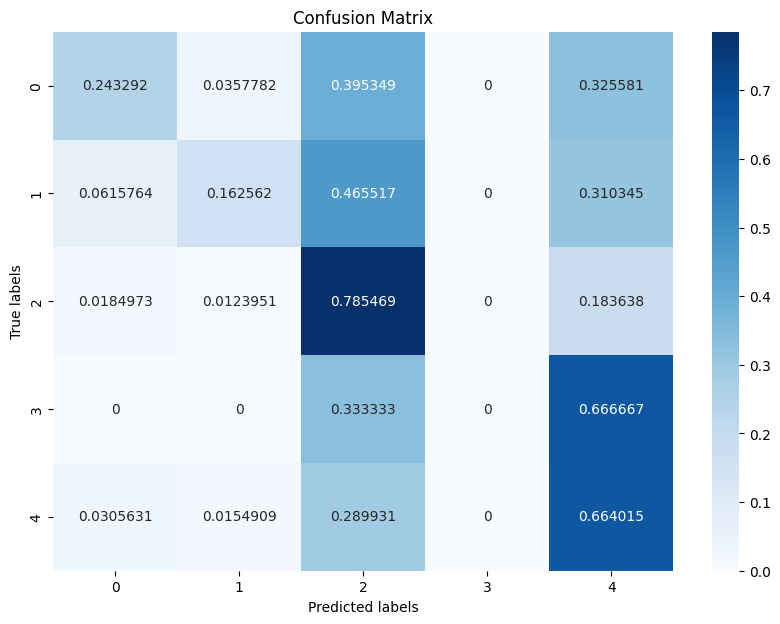

In [ ]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

unique_labels = list(set(y_test) | set(y_pred))

# Plotting using seaborn for a more aesthetic view
plt.figure(figsize=(10, 7))
sns.heatmap(cmn, annot=True, fmt='g', cmap='Blues')


plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create an instance of the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of estimators as needed

# Fit the model to the training data
rf_classifier.fit(x_train, y_train)

# Predict the target values on the test data
y_pred_rf = rf_classifier.predict(x_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
confusion_matrix_rf = confusion_matrix(y_test, y_pred_rf)
classification_report_rf = classification_report(y_test, y_pred_rf)


In [ ]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

# Calculate precision, accuracy, recall, and F1-score
precision = precision_score(y_test, y_pred_rf, average='weighted')
accuracy = accuracy_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf, average='weighted')
f1 = f1_score(y_test, y_pred_rf, average='weighted')

# Print the metrics
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.7127837260740558
Accuracy: 0.7231622998544396
Recall: 0.7231622998544396
F1 Score: 0.7151508533455917


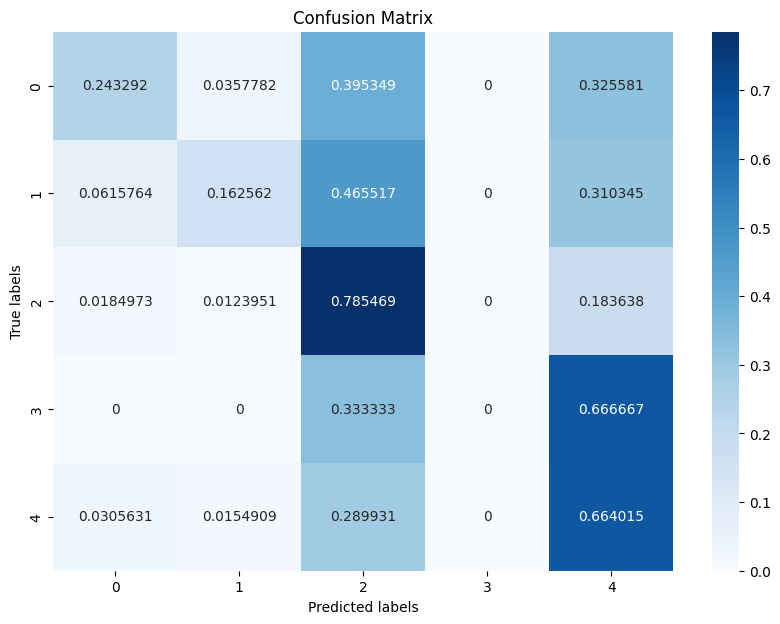

In [ ]:
import seaborn as sns

cm1 = confusion_matrix(y_test, y_pred)
cmn1 = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting using seaborn for a more aesthetic view
plt.figure(figsize=(10, 7))
sns.heatmap(cmn1, annot=True, fmt='g', cmap='Blues' )


plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#### Discussion

**MODEL**

I began by extracting the 'Input' and 'Output' columns from two separate DataFrames to compile a comprehensive list of unique addresses. With these addresses, I created a new DataFrame to serve as the foundation for further analysis.

Then, I proceeded to enrich this DataFrame by merging it with additional data sources. This included balance information, average transaction values, counts of inputs and outputs, total transaction counts, and frequency data, ensuring to fill in any missing data with zeros for a complete dataset.

Next, I incorporated a labeling dataset, which I cleaned by removing unnecessary columns and adjusting the format of the 'address' column for consistency. I then did an 'inner' merge of this cleaned labeling data with my main DataFrame, categorizing each address by type.

For the feature set, I first calculated the top 10 most informative features from my dataset using the SelectKBest feature selection method with mutual information scoring, from those i selected the best five, keeping in consideration to not select features that were redundant, then I separated the data into features (X) and labels (y), and divided them into training and test sets. I standardized the features using StandardScaler to ensure the data was normalized.

With my data prepared, I trained a K-Nearest Neighbors classifier, choosing 5 neighbors based on initial considerations. Once the model was trained, I made predictions on the test set and used a confusion matrix along with F1 Score, Precision, Recall, and Accuracy metrics to evaluate how well my model performed.

As the resoults were unsatisfactory i tried using a Random Forest Classifier with the same 5 features, with this metod the resoults improved drastically.

**RESULTS**

The results of the Random Forest classifier model show a reasonable level of performance. The accuracy of 72.31% alongside a precision of 71.27% indicates that the model is fairly good at predicting the correct classes and is relatively precise in its positive predictions. The recall matches the accuracy, which suggests that the model has a balanced capability of detecting the true positives across classes.

The F1 score, at 71.51%, confirms this balance between precision and recall.

Looking at the confusion matrix, we can see certain classes where the model performs exceptionally well, like class 2, while other classes, like class 3, are not predicted as accurately. This could indicate that some classes are more distinguishable based on the features provided, or that the number of values in labelad as mining are too low (149).



## Part 4

Consider we didn't have the labels for the address, but that you would want to create groups of addresses. Propose a solution.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

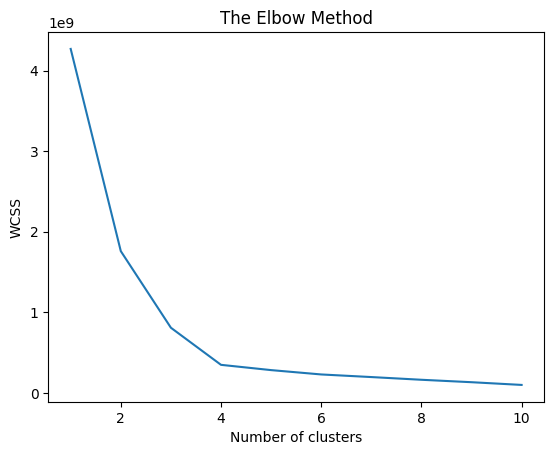

In [ ]:
#data sampling to reduce the dimension of x
c = x.sample(frac=1/3, random_state=42)

#multiclass dataset
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determining the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(c)
    wcss.append(kmeans.inertia_)

# Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within cluster sum of squares
plt.show()

In [ ]:
# Applying k-means to the dataset with the optimal number of clusters
#n_clusters = 4, the optimal number find from the elbow method
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(c)

# Adding the cluster to the dataset
c['Cluster'] = y_kmeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# You already have the clustering results in y_kmeans and your data in c
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(c, y_kmeans)
print(silhouette_avg)

0.9344585975239569


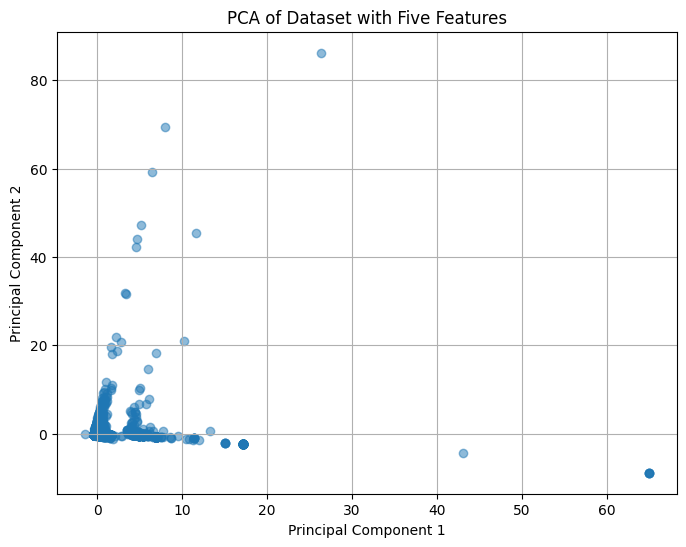

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

scaler = StandardScaler()
df_scaled = scaler.fit_transform(c)

# Initialize PCA and reduce to two components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)

# Create a new dataframe with the two principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Visualize the first two principal components
plt.figure(figsize=(8,6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5)
plt.title('PCA of Dataset with Five Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score without outliers: 0.745121114245294


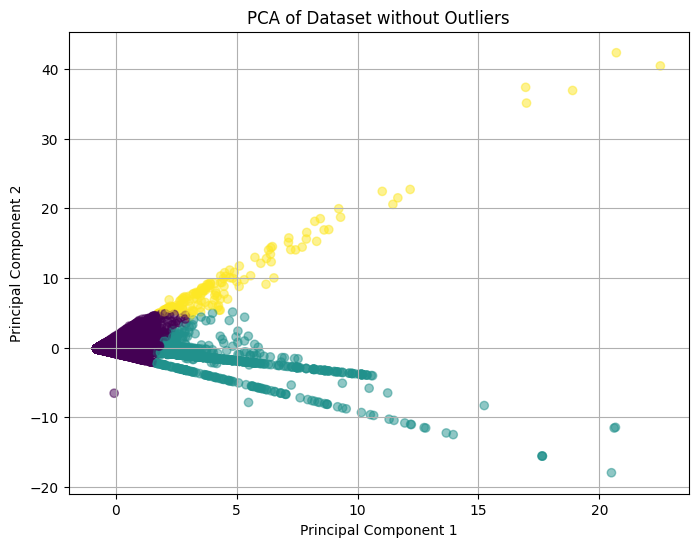

In [ ]:
# Detecting outliers using z-score for PC1 which seems to have the spread
z_scores = np.abs(pca_df['PC1'])
threshold = 3  # Typically a z-score of 3 or -3 is considered an outlier
outliers = np.where(z_scores > threshold)

outlier_indices = c.index[outliers[0]]

# Remove outliers using the indices from the original dataframe
df_no_outliers = c.drop(index=outlier_indices)

# Standardize the data without outliers before re-running PCA
df_scaled_no_outliers = scaler.fit_transform(df_no_outliers)

# Re-run PCA without outliers
pca_no_outliers = PCA(n_components=2)
principal_components_no_outliers = pca_no_outliers.fit_transform(df_scaled_no_outliers)
pca_df_no_outliers = pd.DataFrame(data=principal_components_no_outliers, columns=['PC1', 'PC2'])

# Re-run KMeans without outliers
kmeans_no_outliers = KMeans(n_clusters=3, init='k-means++', random_state=42)
y_kmeans_no_outliers = kmeans_no_outliers.fit_predict(df_scaled_no_outliers)

# Evaluate silhouette score without outliers
silhouette_avg_no_outliers = silhouette_score(df_scaled_no_outliers, y_kmeans_no_outliers)
print('The silhouette score without outliers:', silhouette_avg_no_outliers)

# Plot the PCA results without outliers
plt.figure(figsize=(8, 6))
plt.scatter(pca_df_no_outliers['PC1'], pca_df_no_outliers['PC2'], c=y_kmeans_no_outliers, alpha=0.5)
plt.title('PCA of Dataset without Outliers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score without outliers: 0.745121114245294


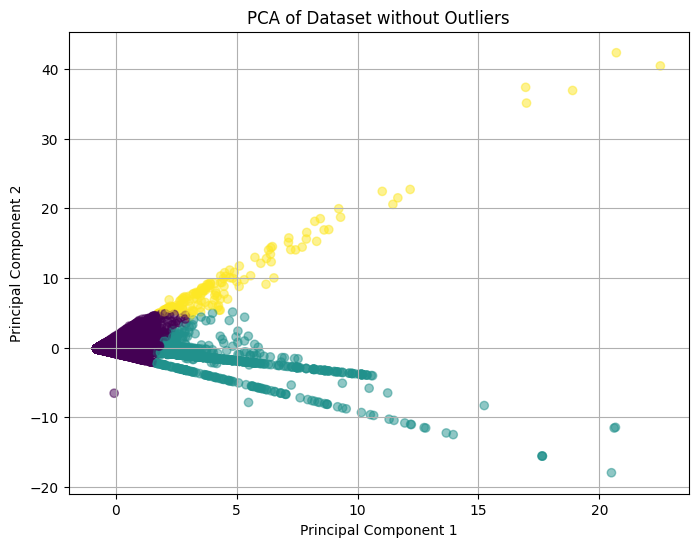

In [ ]:
# Detecting outliers using z-score for PC1 which seems to have the spread
z_scores = np.abs(pca_df['PC1'])
threshold = 3  # Typically a z-score of 3 or -3 is considered an outlier
outliers = np.where(z_scores > threshold)

outlier_indices = c.index[outliers[0]]

# Remove outliers using the indices from the original dataframe
df_no_outliers = c.drop(index=outlier_indices)

# Standardize the data without outliers before re-running PCA
df_scaled_no_outliers = scaler.fit_transform(df_no_outliers)

# Re-run PCA without outliers
pca_no_outliers = PCA(n_components=2)
principal_components_no_outliers = pca_no_outliers.fit_transform(df_scaled_no_outliers)
pca_df_no_outliers = pd.DataFrame(data=principal_components_no_outliers, columns=['PC1', 'PC2'])

# Re-run KMeans without outliers
kmeans_no_outliers = KMeans(n_clusters=3, init='k-means++', random_state=42)
y_kmeans_no_outliers = kmeans_no_outliers.fit_predict(df_scaled_no_outliers)

# Evaluate silhouette score without outliers
silhouette_avg_no_outliers = silhouette_score(df_scaled_no_outliers, y_kmeans_no_outliers)
print('The silhouette score without outliers:', silhouette_avg_no_outliers)

# Plot the PCA results without outliers
plt.figure(figsize=(8, 6))
plt.scatter(pca_df_no_outliers['PC1'], pca_df_no_outliers['PC2'], c=y_kmeans_no_outliers, alpha=0.5)
plt.title('PCA of Dataset without Outliers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

#### Discussion

**Objective:** The primary goal of this analysis was to identify natural groupings within a dataset of addresses without any preexisting labels. By uncovering these groupings, we aimed to understand the underlying structure of the data and potentially discover meaningful patterns.

**Methodology:**
- Data Sampling: A random sample representing one-third of the dataset was selected to ensure computational efficiency and manageability of the data.
- Elbow Method: The Elbow Method was employed to determine the optimal number of clusters. The Within-Cluster Sum of Squares (WCSS) was plotted against the number of clusters, revealing a bend at three clusters, suggesting this as the appropriate choice for KMeans clustering.
- KMeans Clustering: With the optimal cluster count identified, KMeans clustering was performed on the sampled data. The results indicated a very high silhouette score of approximately 0.934, suggesting excellent separation between clusters. However, this score was unusually high for real-world datasets, prompting further investigation into outliers' influence.
- Principal Component Analysis (PCA): PCA was conducted to reduce the dataset to two dimensions for visualization purposes. The scatter plot of the first two principal components showed a wide spread of data points, indicating variance within the dataset.
- Outlier Detection and Removal: Outliers were identified using the z-score method and removed to prevent skewing the clustering results. The PCA scatter plot, post-outlier removal, showed a more concentrated distribution of data points, which were then recolored according to their cluster assignment.
- Silhouette Score Recalculation: After excluding outliers, the silhouette score was recalculated, yielding a score of approximately 0.745. This score, while lower than the initial score, still indicates a strong structure and good separation between clusters in the data.

**Findings:**
The initial clustering, while appearing to be highly distinct, was influenced by outliers. The removal of these outliers led to a decrease in the silhouette score but resulted in a more realistic and reliable clustering model.
The final PCA plot revealed that the clusters were distinct and well-separated in the reduced dimensional space, affirming the effectiveness of the outlier removal process.

**Conclusion:**
The analysis identified meaningful clusters within the addresses dataset. The process highlighted the importance of outlier detection in clustering and demonstrated the utility of PCA in visualizing high-dimensional data. The resulting clusters, validated by a strong silhouette score, offer a foundation for further analysis or operational segmentation strategies.

## Part 5

Pagerank

Use cuDF/cuML/cuGrpahs for 1 extra point.

In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 400, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 400 (delta 95), reused 52 (delta 51), pack-reused 269
Receiving objects: 100% (400/400), 109.76 KiB | 4.99 MiB/s, done.
Resolving deltas: 100% (197/197), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.9 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS cuDF, cuML, and cuGraph via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.6/502.6 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 GB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip uninstall pyarrow
!pip install pyarrow==12.0.01

Found existing installation: pyarrow 12.0.1
Uninstalling pyarrow-12.0.1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/pyarrow-12.0.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/pyarrow/*
Proceed (Y/n)? n


In [ ]:
!pip freeze | grep cudf


In [ ]:
import cudf

In [ ]:
import cudf

# Load the dataset
# Preprocess the data

df = df_joined[['Input', 'Output','Value']].astype(str)
cudf_df = cudf.DataFrame(df)
cudf_df['Value'] = cudf_df['Value'].astype(float)

In [ ]:
import cugraph

# Constructing a directed graph
G = cugraph.Graph(directed=True)
G.from_cudf_edgelist(cudf_df, source='Input', destination='Output', edge_attr='Value')


In [ ]:
# PageRank to find influential nodes
pagerank_scores = cugraph.pagerank(G)




/usr/local/lib/python3.10/dist-packages/cugraph/link_analysis/pagerank.py:227: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)


In [ ]:
pagerank_scores.sort_values('pagerank', ascending= False).head(10)


,pagerank,vertex
784,0.009440,1dice8EMZmqKvrGE4Qc9bUFf9PX3xaYDp
785,0.006673,1dice97ECuByXAvqXpaYzSaQuPVvrtmz6
786,0.004090,1dice7fUkz5h4z2wPc1wLMPWgB5mDwKDx
788,0.003469,1dice9wcMu5hLF4g81u8nioL5mmSHTApw
787,0.003002,1dice7W2AicHosf5EL3GFDUVga7TgtPFn
789,0.002582,1dicegEArYHgbwQZhvr5G9Ah2s7SFuW1y
791,0.002105,1dicec9k7KpmQaA8Uc8aCCxfWnwEWzpXE
792,0.002013,1diceDCd27Cc22HV3qPNZKwGnZ8QwhLTc
795,0.001789,12WfzWsJBrGEzBYstcUZAfQGPZg5KeqGJh
798,0.001611,17Pe4FLUGL2iEWhDgqzN7xF3mYaNugpHsC


#### Discussion

**METOD:**

I loaded a dataset of Bitcoin transactions into a cuDF DataFrame, ensuring all relevant columns were of string type before converting the 'Value' column to a float for numerical operations. Utilizing cuGraph, I then constructed a directed graph to model the flow of transactions, with nodes representing addresses and edges corresponding to transactions weighted by their value. I applied the PageRank algorithm to this graph to quantify the relative influence of each address. Finally, I sorted these PageRank scores in descending order to identify and display the top ten most influential addresses in the Bitcoin network

**RESULTS**

From the results of the pagerank:

1. I noticed that the PageRank scores are not uniform; some addresses have significantly higher scores than others. This variety suggests a typical distribution often seen in real-world networks, where a small number of nodes are highly influential.
Those nodes could be either large exchange wallets, wallets belonging to mining pools, or other significant entities in the cryptocurrency ecosystem.

2. The spread of the PageRank scores gives me insight into the structure of the Bitcoin network from the dataset I analyzed. If there are a few addresses with much higher scores compared to the rest, it could point to a network with certain points of centralization or key hubs.

